In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
mpl.style.use('bmh')

In [3]:
import numpy as np

In [4]:
from lint_analysis.bin_counts import cache

In [5]:
tokens = cache.token_counts(10000)

In [6]:
import re

from collections import OrderedDict

tokens = OrderedDict([
    (t, c) for t, c in tokens.items()
    if not re.match('^[0-9ivx.]+$', t)
])

In [7]:
data = []

for i, (token, count) in enumerate(tokens.items()):
    
    series = cache.token_series(token)
    exp_var = series.sum() * (1/100) * (1 - 1/100)
    
    data.append((count, series.var(), exp_var))
    
    if i % 1000 == 0: print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [9]:
import pandas as pd

df = pd.DataFrame(
    data,
    columns=('count', 'var', 'exp'),
    index=tokens.keys(),
)

In [10]:
import math

df['score'] = df.index.map(
    lambda t: df.loc[t]['var'] / df.loc[t]['exp']
)

In [11]:
top = df.sort_values('score', ascending=False).head(500)

In [12]:
import random

shuffled = list(top.index)
random.shuffle(shuffled)

In [13]:
series = {
    token: cache.token_series(token)
    for token in top.index
}

In [14]:
from itertools import combinations
from scipy.spatial import distance

In [15]:
d = []
for i, (t1, t2) in enumerate(combinations(shuffled, 2)):
    
    s1 = series[t1]
    s2 = series[t2]
    
    d.append(distance.euclidean(s1/s1.sum(), s2/s2.sum()))

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram

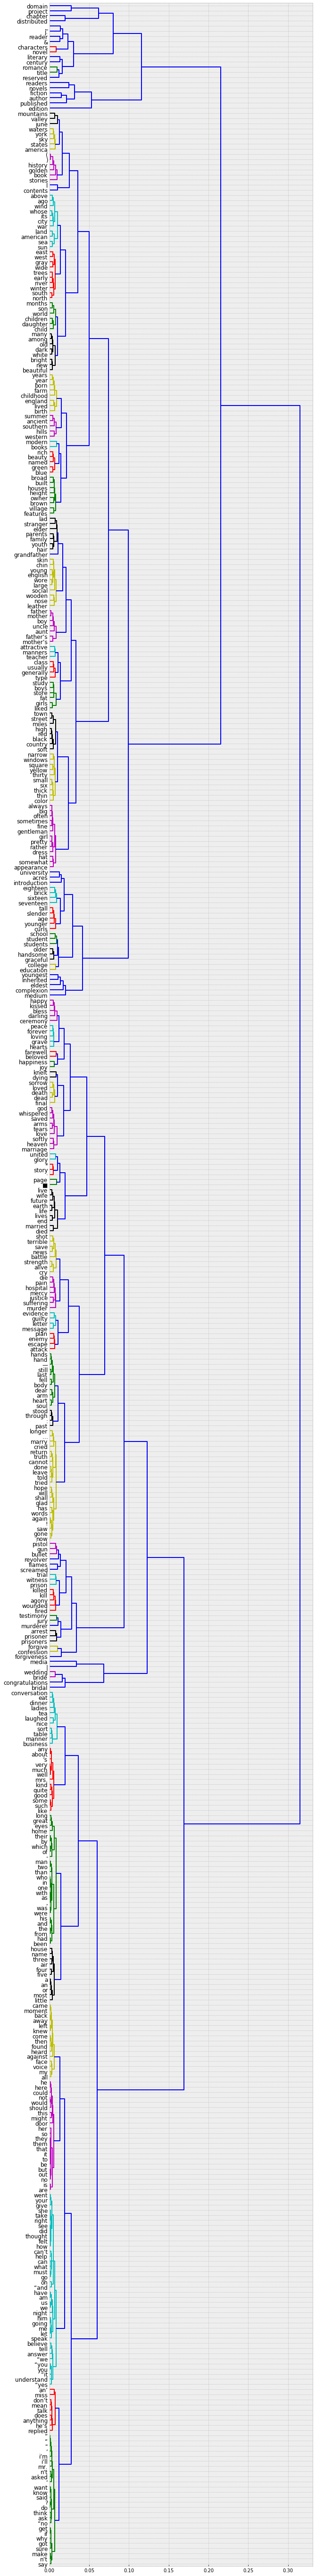

In [17]:
link = linkage(d, method='ward')

plt.figure(figsize=(10, 100))

dendrogram(
    link,
    labels=shuffled,
    orientation='right',
    distance_sort='ascending',
    leaf_font_size=12,
    color_threshold=0.01,
)

plt.show()

In [18]:
from scipy.cluster.hierarchy import fcluster

In [19]:
groups = fcluster(link, 0.01, 'distance')

for gid in range(min(groups), max(groups)+1):
    print('\n', gid)
    for i, j in enumerate(groups):
        if j == gid:
            print(shuffled[i])


 1
n’t
said
’
why
“
if
say
got
‘
ask
i’ll
know
i’m
mr.
sure
"
”
“no
asked
do
want
get
?
n't
make
think

 2
anything
miss
an’
mean
replied
does
talk
don’t
he’s

 3
let
understand
take
what
you
answer
help
your
tell
can
go
felt
can’t
did
am
“and
oh
“yes
going
“you
thought
right
she
we
him
must
went
have
see
night
me
“we
speak
give
“it
believe
how
us

 4
out
to
so
should
be
it
that
could
here
door
would
might
her
not
he
are
no
but
is
them
they
this

 5
all
moment
knew
away
left
voice
against
came
heard
found
face
back
then
come
my

 6
air
five
most
an
three
four
name
little
or
house
a

 7
of
home
and
one
eyes
-
been
which
as
his
from
in
by
two
great
long
were
their
with
man
the
had
who
was
,
than

 8
good
well
about
quite
any
much
very
mrs.
like
’s
such
kind
some

 9
table
nice
eat
business
sort
laughed
conversation
ladies
manner
tea
dinner

 10
bride
wedding

 11
congratulations

 12
bridal

 13
|

 14
media

 15
confession
forgive

 16
forgiveness

 17
prisoners
prisoner
arrest

 18
ju

In [112]:
import math

from scipy.ndimage.measurements import center_of_mass
    
class Cohorts(dict):
        
    def add(self, key, label, tokens):
        
        if type(tokens) is str:
            tokens = list(map(str.strip, token_str.strip().splitlines()))

        self[key] = (label, tokens)
        
    def density(self, key):
        _, tokens = self[key]
        counts = np.array([cache.token_series(token) for token in tokens]).sum(0)
        return counts / counts.sum()
        
    def center_of_mass(self, key):
        density = self.density(key)
        return center_of_mass(np.array(density))[0]
    
    def order_center_of_mass(self):
        return sorted(self.keys(), key=lambda k: self.center_of_mass(k))
    
    def plot_multiples(self, cols=4):

        # Get row count and figure size.
        rows = math.ceil(len(self) / cols)
        
        plt.figure(figsize=(cols*2.5, rows*2.5))
        
        for i, key in enumerate(self.order_center_of_mass()):
            
            label, tokens = self[key]
            
            ax = plt.subplot2grid((rows, cols), (math.floor(i/cols), i%cols))
            
            for token in tokens:

                # Configure axes.
                ax.set_title(label, fontsize=8)
                ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
                ax.tick_params(labelsize=8)

                # Plot the series.
                series = cache.token_series(token.strip())
                ax.plot(series/series.sum(), c='b', lw=0.5)
                
        plt.tight_layout(h_pad=1)
        plt.show()

In [113]:
from textwrap import wrap
from boltons.iterutils import chunked

groups = fcluster(link, 0.01, 'distance')

cohorts = Cohorts()

for gid in range(min(groups), max(groups)+1):
    
    tokens = []
    for i, j in enumerate(groups):
        if j == gid:
            tokens.append(shuffled[i])
            
    if len(tokens) > 2:
        lines = wrap(', '.join(tokens[:10]), 20)
        title = '\n'.join(lines)
        cohorts.add(gid, title, tokens)

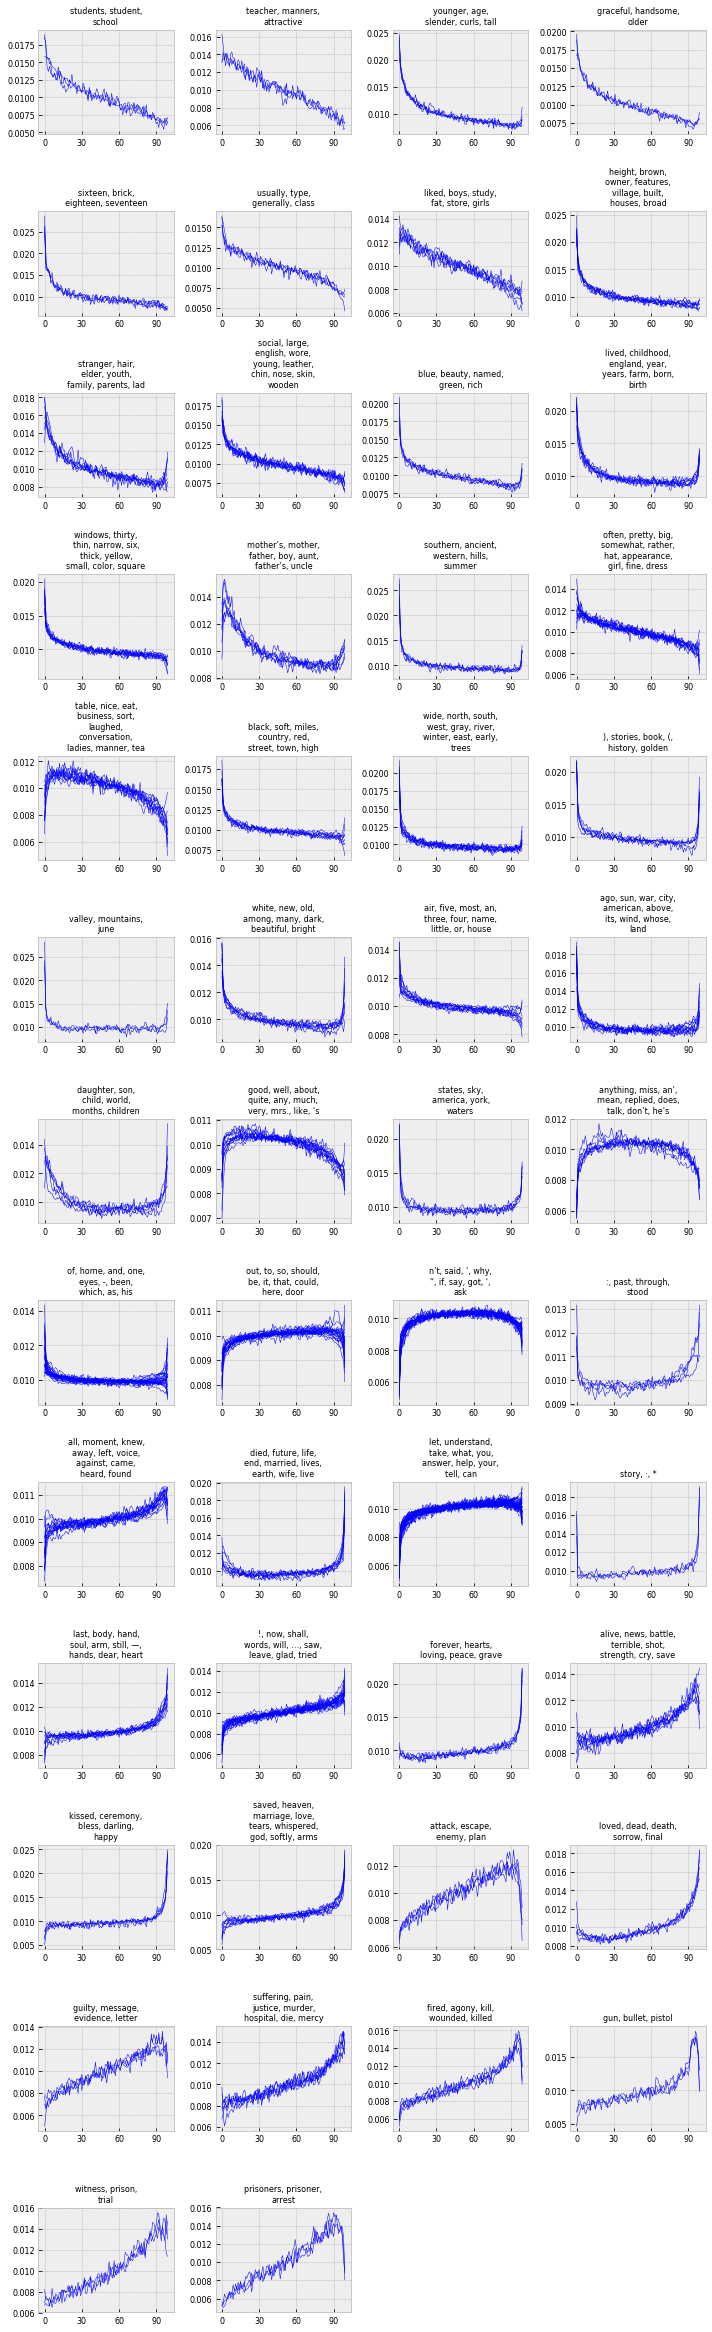

In [114]:
cohorts.plot_multiples()

In [96]:
cohorts = Cohorts()

cohorts.add('paratext', 'Paratext', '''
published
author
fiction
readers
novels
edition
romance
century
literary
title
reserved
characters
reader
novel
chapter
distributed
project
domain
''')

cohorts.add('geography', 'Geographical location, the outdoors', '''
trees
child
sea
months
old
dark
gray
war
world
its
west
south
whose
son
new
wide
winter
north
wind
beautiful
children
daughter
among
early
american
city
ago
bright
river
white
sun
east
land
above
many
golden
valley
book
stories
states
york
sky
june
waters
america
mountains
history
''')

cohorts.add('birth_time_color', 'Birth, time, color', '''
hills
blue
childhood
owner
birth
years
green
england
houses
built
summer
broad
features
books
year
village
height
western
southern
named
brown
born
beauty
lived
rich
ancient
modern
farm
''')

cohorts.add('family_body_youth', 'Family, body, youth', '''
young
lad
hair
wore
stranger
english
mother
youth
grandfather
leather
elder
skin
large
boy
wooden
father
father’s
uncle
nose
parents
aunt
chin
mother’s
family
social
''')

cohorts.add('elementary_school', 'Elementary school (?)', '''
manners
class
liked
generally
usually
boys
fat
type
attractive
girls
study
teacher
store
''')

cohorts.add('size_frequency', 'Size, appearance, frequency (?)', '''
girl
color
six
rather
red
pretty
street
windows
miles
small
country
thin
town
fine
thirty
gentleman
often
sometimes
appearance
black
dress
high
thick
somewhat
yellow
hat
always
big
square
narrow
soft
''')

cohorts.add('age', 'Age (young)', '''
sixteen
tall
slender
university
curls
eighteen
acres
younger
brick
introduction
age
seventeen
''')

cohorts.add('education', 'Education', '''
college
graceful
handsome
older
school
students
education
student
''')

cohorts.add('eldest_youngest', 'Eldest / youngest, complexion', '''
eldest
medium
inherited
complexion
youngest
''')

cohorts.add('joy_love', 'Joy, happiness, affection', '''
joy
happy
farewell
loving
bless
beloved
ceremony
grave
peace
hearts
kissed
happiness
forever
darling
''')

cohorts.add('death_love_marriage', 'Death, love, marriage', '''
dying
saved
arms
knelt
whispered
final
marriage
loved
dead
love
death
tears
sorrow
god
softly
heaven
''')

cohorts.add('life_future', 'Life, future', '''
glory
wife
*
future
united
live
died
■
married
earth
life
lives
page
·
end
story
''')

cohorts.add('war_suffering', 'War, suffering', '''
strength
murder
shot
pain
message
save
plan
battle
alive
attack
die
letter
enemy
evidence
cry
hospital
justice
escape
news
guilty
mercy
terrible
suffering
''')

cohorts.add('exclamations_body_parts', 'Exclamations, body parts involved with expressions of emotion', '''
return
!
…
—
cried
has
longer
:
arm
done
body
again
hand
told
heart
glad
shall
last
hands
will
tried
past
fell
through
leave
dear
cannot
saw
soul
marry
stood
truth
now
words
hope
still
gone
''')

cohorts.add('murder_guns', 'Murder with guns', '''
wounded
screamed
trial
bullet
witness
fired
agony
prison
revolver
pistol
killed
kill
gun
flames
''')

cohorts.add('trial', 'The trial', '''
prisoner
prisoners
testimony
murderer
arrest
jury
''')

cohorts.add('confession', 'Confession, forgiveness', '''
confession
forgiveness
forgive
''')

cohorts.add('marriage', 'Marriage', '''
wedding
bridal
bride
congratulations
''')

cohorts.add('women_eating', 'Pleasant women, eating food', '''
dinner
table
manner
about
tea
eat
quite
mrs.
very
such
some
well
business
kind
much
ladies
nice
laughed
like
conversation
good
any
’s
sort
''')

NameError: name 'token_str' is not defined

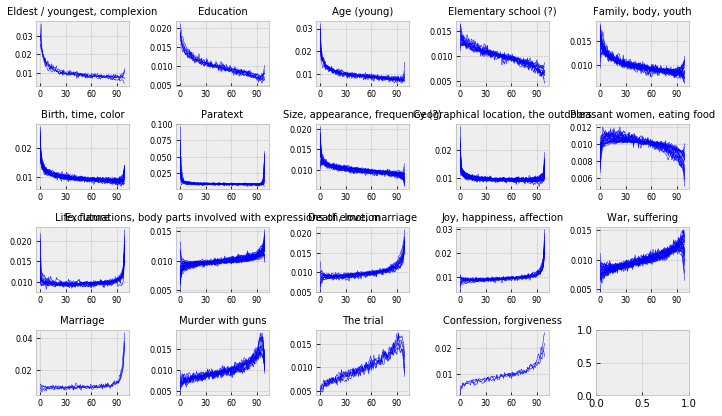

In [26]:
cohorts.plot_multiples()